In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
plt.style.use('../fullwidth.mplstyle')
cmap = matplotlib.colormaps.get_cmap('tab10').colors
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'h']
%matplotlib widget

# 1.4 - Calibration

[Text(0.5, 0, 'TDC channel'),
 Text(0, 0.5, 'Counts'),
 (200.0, 1000.0),
 (0.0, 3000.0)]

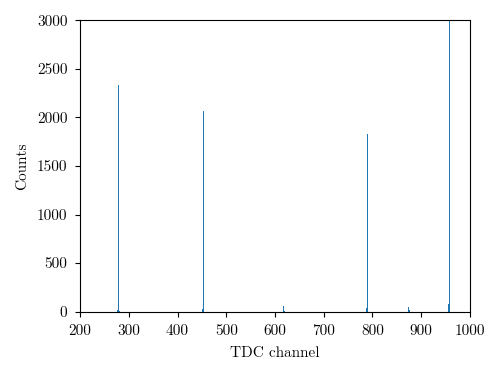

In [3]:
basepath = 'D:/Cosmic_rays/M613/1_4/Co_cal'
paths = [basepath + '_A_tdc_a.txt', basepath + '_B_tdc_b.txt', basepath + '_C_tdc_c.txt', basepath + '_D_tdc_d.txt']
fig,ax = plt.subplots()
data = np.loadtxt(paths[0])
ax.bar(data[:,0], data[:,1], width=1)
ax.set(xlabel='TDC channel', ylabel='Counts', xlim=(200, 1000), ylim=(0, 3000))

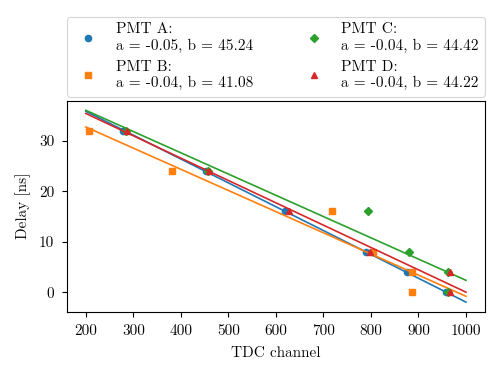

In [4]:
delays = [32,24,16,8,4,0] # ns; from left to right
fig,ax = plt.subplots()
lin = lambda x, a, b: a * x + b
time_calibration_values = []
for i,path in enumerate(paths):
    data = np.loadtxt(path)
    # get tdc channels of the 6 highest counts
    tdc = np.sort(np.argsort(data[:,1])[-6:]) + 1 # 0 based indexing
    popt, _ = curve_fit(lin, tdc, delays)
    time_calibration_values.append(popt)
    label = 'PMT ' + os.path.basename(path).split('_')[2] + ': \na = {:.2f}, b = {:.2f}'.format(popt[0], popt[1])
    ax.plot(tdc, delays, label=label, marker=markers[i], color=cmap[i], linestyle='None')
    ax.plot(np.linspace(200,1000,3), lin(np.linspace(200,1000,3), *popt), color=cmap[i])
    
ax.set(xlabel='TDC channel', ylabel='Delay [ns]')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=2, mode="expand", borderaxespad=0.)
time_calibration_values = np.array(time_calibration_values)
np.savetxt('time_calibration_values.txt', time_calibration_values, header='Time calibration values for PMT A-D. \nADC channel -> Time [ns] conversion: t = slope * ADC + yintersept\nRows correspond to PMT A-D\n\nslope \t\t\t\t y_intersept')

In [5]:
ecal = np.zeros((4,3))

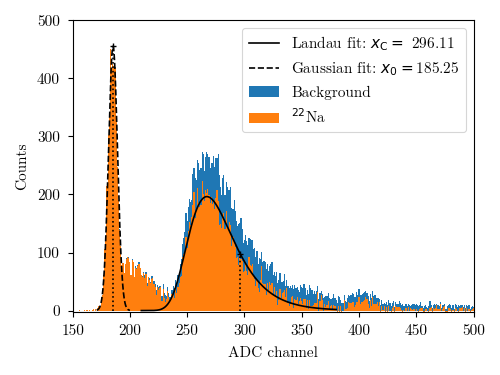

In [6]:
def moyal(x,a,b,c):
    return a * np.exp(-b*(x-c)) * np.exp(-np.exp(-b*(x-c)))  
def gauss(x, a, b, c):
    return a * np.exp(-0.5 * ((x - b) / c) ** 2)
basepath = 'D:/Cosmic_rays/M613/1_4/Na_cal'
paths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Nosource_cal'
calpaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
data = np.loadtxt(paths[0])
cal = np.loadtxt(calpaths[0])

fig,ax = plt.subplots()
ax.bar(data[:,0], data[:,1], width=1, label='Background')
ax.bar(data[:,0], data[:,1] - cal[:,1], width=1, label='$^{22}$Na')

popt, pcov = curve_fit(moyal, data[230:350,0], data[230:350,1] - cal[230:350,1], p0=(100, 0.01, 300), sigma=np.sqrt(np.abs(data[230:350,1] - cal[230:350,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(210, 380, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')

popt, pcov = curve_fit(gauss, data[150:200,0], data[150:200,1] - cal[150:200,1], p0=(400, 185, 10), bounds= [0, [500, 200, 100]], sigma=np.sqrt(np.abs(data[150:200,1] - cal[150:200,1]) +0.01), absolute_sigma=True)
x_gauss = np.linspace(171, 200, 1000)
y_gauss = gauss(x_gauss, *popt)
ax.plot(x_gauss, y_gauss, color='black', linestyle='--', label='Gaussian fit: $x_0=${:.2f}'.format(popt[1]))
ax.plot([popt[1], popt[1]], [0, popt[0]], color='black', linestyle=':')
ax.plot(popt[1], popt[0], marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(150,500), ylim=(-2, 500))
ax.legend()

ecal[0,0] = fwhm
ecal[0,1] = popt[1]

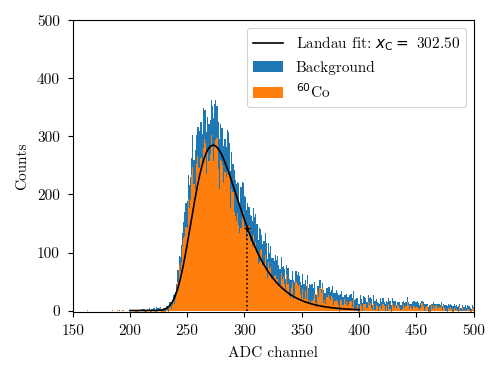

In [7]:
basepath = 'D:/Cosmic_rays/M613/1_4/Co_cal'
paths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Nosource_cal'
calpaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
data = np.loadtxt(paths[0])
cal = np.loadtxt(calpaths[0])

fig,ax = plt.subplots()
ax.bar(data[:,0], data[:,1], width=1, label='Background')
ax.bar(data[:,0], data[:,1] - cal[:,1], width=1, label='$^{60}$Co')

popt, pcov = curve_fit(moyal, data[200:400,0], data[200:400,1] - cal[200:400,1], p0=(300, 0.01, 300), sigma=np.sqrt(np.abs(data[200:400,1] - cal[200:400,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(200, 400, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')

ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(150,500), ylim=(-2, 500))
ax.legend()

ecal[0,2] = fwhm

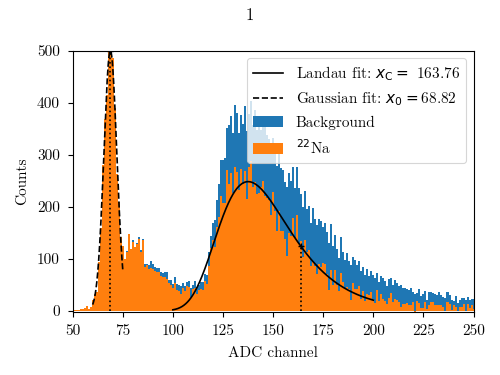

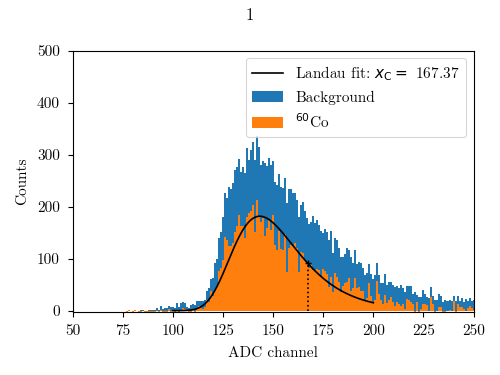

In [8]:
basepath = 'D:/Cosmic_rays/M613/1_4/Na_cal'
napaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Co_cal'
copaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Nosource_cal'
calpaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
i = 1
co = np.loadtxt(copaths[i])
na = np.loadtxt(napaths[i])
cal = np.loadtxt(calpaths[i])
fig,ax = plt.subplots()
ax.bar(na[:,0], na[:,1], width=1, label='Background')
ax.bar(na[:,0], na[:,1] - cal[:,1], width=1, label='$^{22}$Na')

popt, pcov = curve_fit(moyal, na[100:200,0], na[100:200,1] - cal[100:200,1], p0=(100, 0.01, 300), sigma=np.sqrt(np.abs(na[100:200,1] - cal[100:200,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(100, 200, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')

popt, pcov = curve_fit(gauss, na[60:75,0], na[60:75,1] - cal[60:75,1], p0=(400, 65, 10), bounds= [0, [500, 100, 10]], sigma=np.sqrt(np.abs(na[60:75,1] - cal[60:75,1]) +0.01), absolute_sigma=True)
x_gauss = np.linspace(60, 75, 1000)
y_gauss = gauss(x_gauss, *popt)
ax.plot(x_gauss, y_gauss, color='black', linestyle='--', label='Gaussian fit: $x_0=${:.2f}'.format(popt[1]))
ax.plot([popt[1], popt[1]], [0, popt[0]], color='black', linestyle=':')
ax.plot(popt[1], popt[0], marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(50,250), ylim=(-2, 500))
ax.legend()
fig.suptitle(i)
ecal[i,0] = fwhm
ecal[i,1] = popt[1]

fig,ax = plt.subplots()
ax.bar(co[:,0], co[:,1], width=1, label='Background')
ax.bar(co[:,0], co[:,1] - cal[:,1], width=1, label='$^{60}$Co')

popt, pcov = curve_fit(moyal, co[100:200,0], co[100:200,1] - cal[100:200,1], p0=(300, 0.01, 300), sigma=np.sqrt(np.abs(co[100:200,1] - cal[100:200,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(100, 200, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(50,250), ylim=(-2, 500))
ax.legend()
fig.suptitle(i)
ecal[i,2] = fwhm

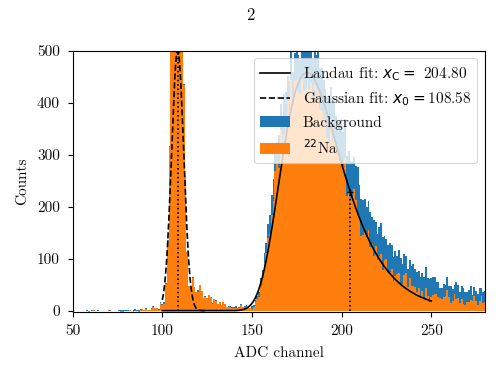

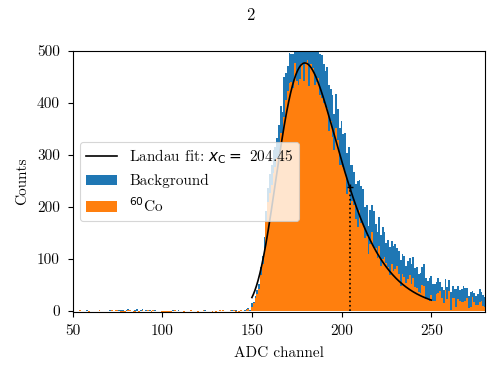

In [9]:
basepath = 'D:/Cosmic_rays/M613/1_4/Na_cal'
napaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Co_cal'
copaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Nosource_cal'
calpaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
i = 2
co = np.loadtxt(copaths[i])
na = np.loadtxt(napaths[i])
cal = np.loadtxt(calpaths[i])
fig,ax = plt.subplots()
ax.bar(na[:,0], na[:,1], width=1, label='Background')
ax.bar(na[:,0], na[:,1] - cal[:,1], width=1, label='$^{22}$Na')

popt, pcov = curve_fit(moyal, na[100:250,0], na[100:250,1] - cal[100:250,1], p0=(100, 0.01, 300), sigma=np.sqrt(np.abs(na[100:250,1] - cal[100:250,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(100, 250, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')

popt, pcov = curve_fit(gauss, na[100:125,0], na[100:125,1] - cal[100:125,1], p0=(400, 110, 10), bounds= [0, [500, 200, 10]], sigma=np.sqrt(np.abs(na[100:125,1] - cal[100:125,1]) +0.01), absolute_sigma=True)
x_gauss = np.linspace(100, 125, 1000)
y_gauss = gauss(x_gauss, *popt)
ax.plot(x_gauss, y_gauss, color='black', linestyle='--', label='Gaussian fit: $x_0=${:.2f}'.format(popt[1]))
ax.plot([popt[1], popt[1]], [0, popt[0]], color='black', linestyle=':')
ax.plot(popt[1], popt[0], marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(50,280), ylim=(-2, 500))
ax.legend()
fig.suptitle(i)
ecal[i,0] = fwhm
ecal[i,1] = popt[1]

fig,ax = plt.subplots()
ax.bar(co[:,0], co[:,1], width=1, label='Background')
ax.bar(co[:,0], co[:,1] - cal[:,1], width=1, label='$^{60}$Co')

popt, pcov = curve_fit(moyal, co[150:250,0], co[150:250,1] - cal[150:250,1], p0=(300, 0.01, 300), sigma=np.sqrt(np.abs(co[150:250,1] - cal[150:250,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(150, 250, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(50,280), ylim=(-2, 500))
ax.legend()
fig.suptitle(i)
ecal[i,2] = fwhm

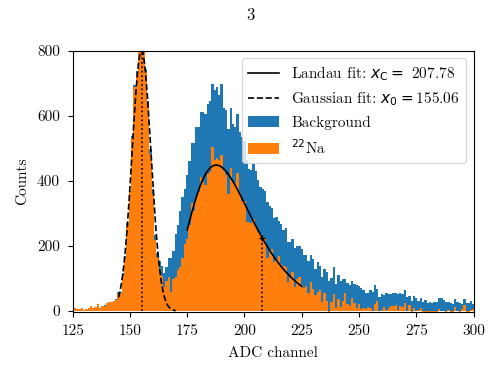

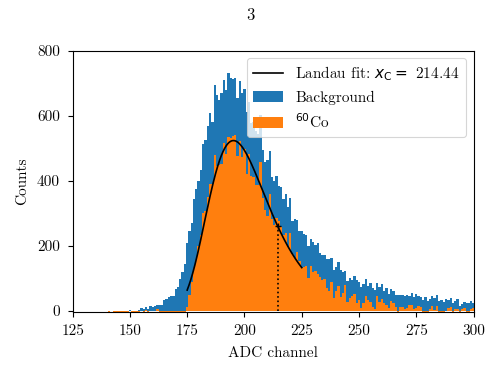

In [10]:
basepath = 'D:/Cosmic_rays/M613/1_4/Na_cal'
napaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Co_cal'
copaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
basepath = 'D:/Cosmic_rays/M613/1_4/Nosource_cal'
calpaths = [basepath + '_A_adc_a.txt', basepath + '_B_adc_b.txt', basepath + '_C_adc_c.txt', basepath + '_D_adc_d.txt']
i = 3
co = np.loadtxt(copaths[i])
na = np.loadtxt(napaths[i])
cal = np.loadtxt(calpaths[i])
fig,ax = plt.subplots()
ax.bar(na[:,0], na[:,1], width=1, label='Background')
ax.bar(na[:,0], na[:,1] - cal[:,1], width=1, label='$^{22}$Na')

popt, pcov = curve_fit(moyal, na[175:225,0], na[175:225,1] - cal[175:225,1], p0=(175, 0.01, 300), sigma=np.sqrt(np.abs(na[175:225,1] - cal[175:225,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(175, 225, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')

popt, pcov = curve_fit(gauss, na[145:170,0], na[145:170,1] - cal[145:170,1], p0=(600, 150, 10), bounds= [0, [800, 200, 10]], sigma=np.sqrt(np.abs(na[145:170,1] - cal[145:170,1]) +0.01), absolute_sigma=True)
x_gauss = np.linspace(145, 170, 1000)
y_gauss = gauss(x_gauss, *popt)
ax.plot(x_gauss, y_gauss, color='black', linestyle='--', label='Gaussian fit: $x_0=${:.2f}'.format(popt[1]))
ax.plot([popt[1], popt[1]], [0, popt[0]], color='black', linestyle=':')
ax.plot(popt[1], popt[0], marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(125,300), ylim=(-2, 800))
ax.legend()
fig.suptitle(i)
ecal[i,0] = fwhm
ecal[i,1] = popt[1]

fig,ax = plt.subplots()
ax.bar(co[:,0], co[:,1], width=1, label='Background')
ax.bar(co[:,0], co[:,1] - cal[:,1], width=1, label='$^{60}$Co')

popt, pcov = curve_fit(moyal, co[175:225,0], co[175:225,1] - cal[175:225,1], p0=(300, 0.01, 300), sigma=np.sqrt(np.abs(co[175:225,1] - cal[175:225,1]) +0.01), absolute_sigma=True)
x_moyal = np.linspace(175, 225, 1000)
y_moyal = moyal(x_moyal, *popt)
loc_fwhm = np.abs(y_moyal[np.argmax(y_moyal):] - np.max(y_moyal)/2).argmin()
fwhm = x_moyal[np.argmax(y_moyal):][loc_fwhm] 
ax.plot(x_moyal, y_moyal, color='black', label='Landau fit: $x_\mathrm{C}=$'+' {:.2f}'.format(fwhm))
ax.plot([fwhm, fwhm], [0, np.max(y_moyal)/2], color='black', linestyle=':')
ax.plot(fwhm, np.max(y_moyal)/2, marker='+', color='black')
ax.set(xlabel='ADC channel', ylabel='Counts', xlim=(125,300), ylim=(-2, 800))
ax.legend()
fig.suptitle(i)
ecal[i,2] = fwhm

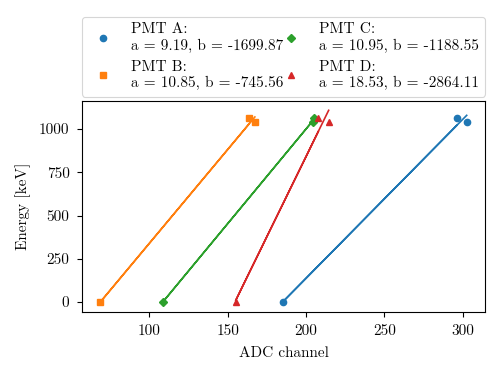

In [ ]:
energies = np.array([1062.2, 0, (963.2+1117.62)/2]) # keV
lin = lambda x, a, b: a * x + b
energy_calibration_values = []
fig,ax = plt.subplots()
for i in range(4):
    adc = np.array([ecal[i,0], ecal[i,1], ecal[i,2]])
    popt, _ = curve_fit(lin, adc, energies)
    energy_calibration_values.append(popt)
    label = 'PMT ' +chr(65+i) + ': \na = {:.2f}, b = {:.2f}'.format(popt[0], popt[1])
    ax.plot(adc, lin(adc, *popt), color=cmap[i])
    ax.plot(adc, energies, label=label, marker=markers[i], color=cmap[i], linestyle='None')
ax.set( xlabel='ADC channel', ylabel='Energy [keV]')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncols=2, mode="expand", borderaxespad=0.)
energy_calibration_values = np.array(energy_calibration_values)
np.savetxt('energy_calibration_values.txt', energy_calibration_values, header='Energy calibration values for PMT A-D. \nADC channel -> Energy [keV] conversion: E = slope * ADC + yintersept\nRows correspond to PMT A-D\n\nslope \t\t\t\t y_intersept')

In [12]:
time_calibration_values = np.loadtxt('time_calibration_values.txt')
energy_calibration_values = np.loadtxt('energy_calibration_values.txt')
def time_cal(tdc, which):
    if which == 'A':
        a, b = time_calibration_values[0]
    elif which == 'B':  
        a, b = time_calibration_values[1]
    elif which == 'C':
        a, b = time_calibration_values[2]
    elif which == 'D':
        a, b = time_calibration_values[3]
    return a * tdc + b
def energy_cal(adc, which):
    if which == 'A':
        a, b = energy_calibration_values[0]
    elif which == 'B':  
        a, b = energy_calibration_values[1]
    elif which == 'C':
        a, b = energy_calibration_values[2]
    elif which == 'D':
        a, b = energy_calibration_values[3]
    return a * adc + b

# 1.5 - Overlap coincidence

In [34]:
plt.close('all')
%matplotlib inline

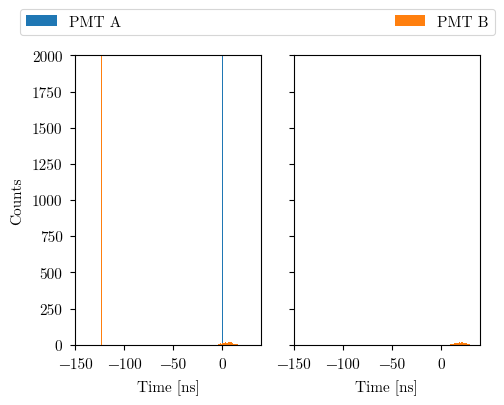

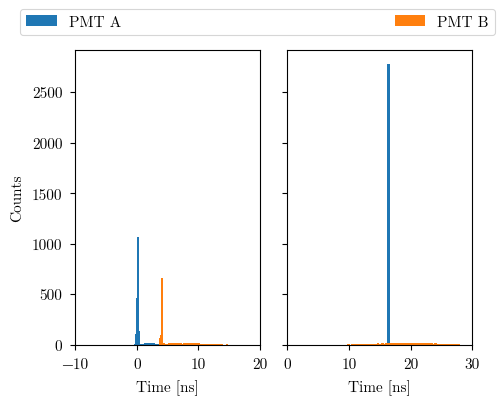

In [67]:
paths = [
    ['D:/Cosmic_rays/M613/1_5/1d/A_nodelay_tdc_a.txt', 'D:/Cosmic_rays/M613/1_5/1d/A_nodelay_tdc_b.txt'],
    ['D:/Cosmic_rays/M613/1_5/1d/A_16ns_tdc_a.txt', 'D:/Cosmic_rays/M613/1_5/1d/A_16ns_tdc_b.txt'],     
     
    ['D:/Cosmic_rays/M613/1_5/1d/AB_nodelay_tdc_a.txt', 'D:/Cosmic_rays/M613/1_5/1d/AB_nodelay_tdc_b.txt'],
    ['D:/Cosmic_rays/M613/1_5/1d/AB_16ns_tdc_a.txt', 'D:/Cosmic_rays/M613/1_5/1d/AB_16ns_tdc_b.txt']    
    ]
width_a = np.abs(time_cal(1, 'A') - time_cal(0, 'A'))
width_b = np.abs(time_cal(1, 'B') - time_cal(0, 'B'))
fig,ax = plt.subplots(ncols=2, sharey=True)
p = paths[0]
data_a = np.loadtxt(p[0])
data_b = np.loadtxt(p[1])
ax[0].bar(time_cal(data_a[:,0], 'A'), data_a[:,1], width=10*width_a, label='PMT A')
ax[0].bar(time_cal(data_b[:,0], 'B'), data_b[:,1], width=10*width_b, label='PMT B')
ax[0].set(xlabel='Time [ns]', ylabel='Counts', ylim=(0, 2000), xlim=(-150,40))
p = paths[1]
data_a = np.loadtxt(p[0])
data_b = np.loadtxt(p[1])
ax[1].bar(time_cal(data_a[:,0], 'A'), data_a[:,1], width=10*width_a)
ax[1].bar(time_cal(data_b[:,0], 'B'), data_b[:,1], width=10*width_b)
ax[1].set(xlabel='Time [ns]', ylim=(0, 2000), xlim=(-150,40))
fig.legend(bbox_to_anchor=(0.05, 1., 0.95, .10), loc='lower left', ncols=2, mode="expand", borderaxespad=0.)


fig,ax = plt.subplots(ncols=2, sharey=True)
p = paths[2]
data_a = np.loadtxt(p[0])
data_b = np.loadtxt(p[1])
ax[0].bar(time_cal(data_a[:,0], 'A'), data_a[:,1], width=10*width_a, label='PMT A')
ax[0].bar(time_cal(data_b[:,0], 'B'), data_b[:,1], width=10*width_b, label='PMT B')
ax[0].set(xlim=(-10,20), xlabel='Time [ns]', ylabel='Counts')
p = paths[3]
data_a = np.loadtxt(p[0])
data_b = np.loadtxt(p[1])
ax[1].bar(time_cal(data_a[:,0], 'A'), data_a[:,1], width=10*width_a)
ax[1].bar(time_cal(data_b[:,0], 'B'), data_b[:,1], width=10*width_b)
ax[1].set(xlim=(-0,30), xlabel='Time [ns]')
fig.legend(bbox_to_anchor=(0.05, 1., 0.95, .10), loc='lower left', ncols=2, mode="expand", borderaxespad=0.)

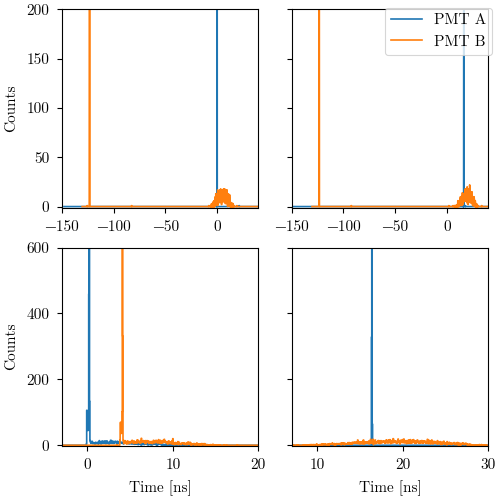

In [188]:
paths = [
    ['D:/Cosmic_rays/M613/1_5/1d/A_nodelay_tdc_a.txt', 'D:/Cosmic_rays/M613/1_5/1d/A_nodelay_tdc_b.txt'],
    ['D:/Cosmic_rays/M613/1_5/1d/A_16ns_tdc_a.txt', 'D:/Cosmic_rays/M613/1_5/1d/A_16ns_tdc_b.txt'],     
     
    ['D:/Cosmic_rays/M613/1_5/1d/AB_nodelay_tdc_a.txt', 'D:/Cosmic_rays/M613/1_5/1d/AB_nodelay_tdc_b.txt'],
    ['D:/Cosmic_rays/M613/1_5/1d/AB_16ns_tdc_a.txt', 'D:/Cosmic_rays/M613/1_5/1d/AB_16ns_tdc_b.txt']    
    ]
width_a = np.abs(time_cal(1, 'A') - time_cal(0, 'A'))
width_b = np.abs(time_cal(1, 'B') - time_cal(0, 'B'))
fig,ax = plt.subplots(ncols=2, nrows=2, sharey='row', layout='constrained', figsize=(5,3.75*4/3))
p = paths[0]
data_a = np.loadtxt(p[0])
data_b = np.loadtxt(p[1])
ax[0,0].step(time_cal(data_a[:,0], 'A'), data_a[:,1], label='PMT A')
ax[0,0].step(time_cal(data_b[:,0], 'B'), data_b[:,1], label='PMT B')
ax[0,0].set( ylabel='Counts', ylim=(-1, 200), xlim=(-150,40))
p = paths[1]
data_a = np.loadtxt(p[0])
data_b = np.loadtxt(p[1])
ax[0,1].step(time_cal(data_a[:,0], 'A'), data_a[:,1] )
ax[0,1].step(time_cal(data_b[:,0], 'B'), data_b[:,1] )
ax[0,1].set( xlim=(-150,40))

p = paths[2]
data_a = np.loadtxt(p[0])
data_b = np.loadtxt(p[1])
ax[1,0].step(time_cal(data_a[:,0], 'A'), data_a[:,1])
ax[1,0].step(time_cal(data_b[:,0], 'B'), data_b[:,1])
ax[1,0].set(xlim=(-3,20), ylim=(-1,600), xlabel='Time [ns]', ylabel='Counts')
p = paths[3]
data_a = np.loadtxt(p[0])
data_b = np.loadtxt(p[1])
ax[1,1].step(time_cal(data_a[:,0], 'A'), data_a[:,1])
ax[1,1].step(time_cal(data_b[:,0], 'B'), data_b[:,1])
ax[1,1].set(xlim=(7,30), xlabel='Time [ns]')
fig.legend()


# 2.1 - Attenuation

Text(0.02, 0.5, 'Counts')

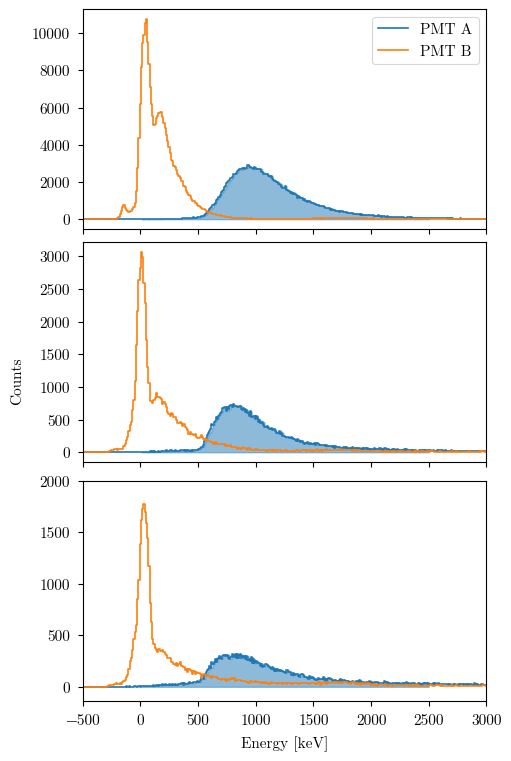

In [86]:
paths = [['D:/Cosmic_rays/M613/2_1/A_nearA_adc_a.txt', 'D:/Cosmic_rays/M613/2_1/A_nearA_adc_b.txt'],
         ['D:/Cosmic_rays/M613/2_1/A_center_adc_a.txt', 'D:/Cosmic_rays/M613/2_1/A_center_adc_b.txt'],
         ['D:/Cosmic_rays/M613/2_1/A_nearB_adc_a.txt', 'D:/Cosmic_rays/M613/2_1/A_nearB_adc_b.txt']]
int_a = np.zeros(3)
width_a = np.abs(energy_cal(1, 'A') - energy_cal(0, 'A'))
width_b = np.abs(energy_cal(1, 'B') - energy_cal(0, 'B'))
fig,ax = plt.subplots(nrows=3, figsize=(5,3.75*2), sharex=True,layout='constrained')
p = paths[0]
ch_a = np.loadtxt(p[0])
ch_b = np.loadtxt(p[1])
mask_a = (energy_cal(ch_a[:,0], 'A') > 0) & ( energy_cal(ch_a[:,0], 'A') < 2500)
ax[0].step(energy_cal(ch_a[:,0], 'A'), ch_a[:,1], label='PMT A')
ax[0].fill_between(energy_cal(ch_a[:,0], 'A')[mask_a], ch_a[:,1][mask_a], step='post', alpha=0.5, color=cmap[0])
ax[0].step(energy_cal(ch_b[:,0], 'B'), ch_b[:,1], label='PMT B')
ax[0].set( xlim=(-500, 3000))
int_a[0] = np.sum(ch_a[:,1][mask_a])
p = paths[1]
ch_a = np.loadtxt(p[0])
ch_b = np.loadtxt(p[1])
ax[1].step(energy_cal(ch_a[:,0], 'A'), ch_a[:,1])
ax[1].fill_between(energy_cal(ch_a[:,0], 'A')[mask_a], ch_a[:,1][mask_a], step='post', alpha=0.5, color=cmap[0])
ax[1].step(energy_cal(ch_b[:,0], 'B'), ch_b[:,1])
ax[1].set( xlim=(-500, 3000))
int_a[1] = np.sum(ch_a[:,1][mask_a])
p = paths[2]
ch_a = np.loadtxt(p[0])
ch_b = np.loadtxt(p[1])
ax[2].step(energy_cal(ch_a[:,0], 'A'), ch_a[:,1])
ax[2].fill_between(energy_cal(ch_a[:,0], 'A')[mask_a], ch_a[:,1][mask_a], step='post', alpha=0.5, color=cmap[0])
ax[2].step(energy_cal(ch_b[:,0], 'B'), ch_b[:,1])
ax[2].set(xlabel='Energy [keV]', xlim=(-500, 3000), ylim=(None,2000))
ax[0].legend()
int_a[2] = np.sum(ch_a[:,1][mask_a])
fig.supylabel('Counts', fontsize=11)

C:\Users\steph\AppData\Local\Temp\ipykernel_12508\4125685772.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x + c)


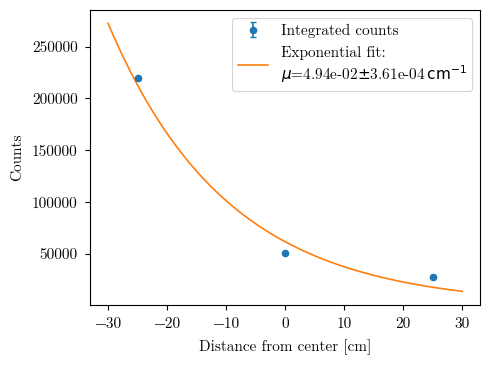

In [99]:
def exponential(x, a, b,c):
    return a * np.exp(-b * x + c)
fig,ax = plt.subplots()
ax.errorbar([-25,0,25], int_a, np.sqrt(int_a), None, 'o', label='Integrated counts')
ax.set(xlabel='Distance from center [cm]', ylabel='Counts')
popt, pcov = curve_fit(exponential, [-25,0,25], int_a, sigma=np.sqrt(int_a), absolute_sigma=True)
x = np.linspace(-30, 30, 1000)
ax.plot(x, exponential(x, *popt), label='Exponential fit: \n$\mu$={:.2e}$\pm${:.2e}'.format(popt[1], np.sqrt(pcov[1,1]))+'$\,\mathrm{cm^{-1}}$')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

# 2.2 - Free and coincident energy spectra

Integrated count rates for PMT A:
 7322.285714285715 707.5714285714286 1/min


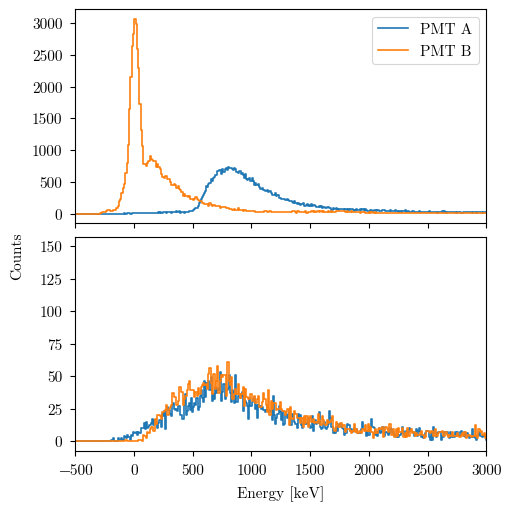

In [105]:
paths = [['D:/Cosmic_rays/M613/2_1/A_center_adc_a.txt', 'D:/Cosmic_rays/M613/2_1/A_center_adc_b.txt'],
         ['D:/Cosmic_rays/M613/2_2/AB_center_adc_a.txt', 'D:/Cosmic_rays/M613/2_2/AB_center_adc_b.txt']]

int_a = np.zeros(2)
fig,ax = plt.subplots(nrows=2, figsize=(5,3.75*4/3), sharex=True,layout='constrained')
p = paths[0]
ch_a = np.loadtxt(p[0])
ch_b = np.loadtxt(p[1])
mask_a = (energy_cal(ch_a[:,0], 'A') > 0) & ( energy_cal(ch_a[:,0], 'A') < 2500)
ax[0].step(energy_cal(ch_a[:,0], 'A'), ch_a[:,1], label='PMT A')
ax[0].step(energy_cal(ch_b[:,0], 'B'), ch_b[:,1], label='PMT B')
ax[0].set( xlim=(-500, 3000))
ax[0].legend()
int_a[0] = np.sum(ch_a[:,1][mask_a])
p = paths[1]
ch_a = np.loadtxt(p[0])
ch_b = np.loadtxt(p[1])
ax[1].step(energy_cal(ch_a[:,0], 'A'), ch_a[:,1])
ax[1].step(energy_cal(ch_b[:,0], 'B'), ch_b[:,1])
ax[1].set( xlim=(-500, 3000))
ax[1].set(xlabel='Energy [keV]')
fig.supylabel('Counts', fontsize=11)
int_a[1] = np.sum(ch_a[:,1][mask_a])
print('Integrated count rates for PMT A:\n', int_a[0]/7, int_a[1]/7, '1/min')

# 2.3 - Speed of light

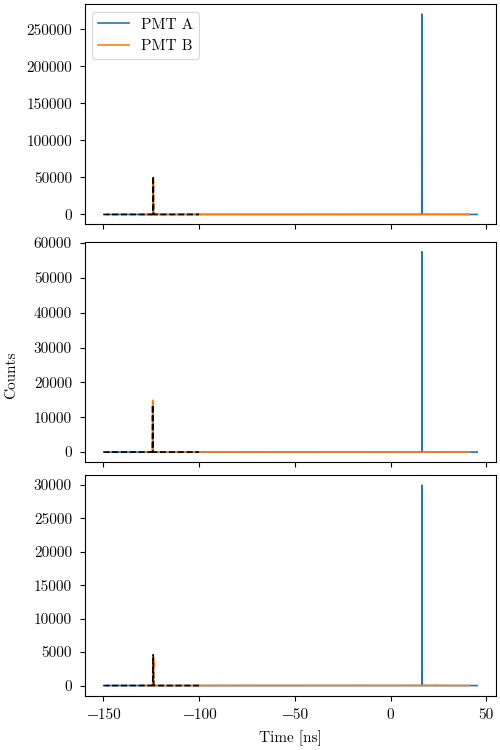

In [193]:
%matplotlib widget
paths = [['D:/Cosmic_rays/M613/2_1/A_nearA_tdc_a.txt', 'D:/Cosmic_rays/M613/2_1/A_nearA_tdc_b.txt'],
         ['D:/Cosmic_rays/M613/2_1/A_center_tdc_a.txt', 'D:/Cosmic_rays/M613/2_1/A_center_tdc_b.txt'],
         ['D:/Cosmic_rays/M613/2_1/A_nearB_tdc_a.txt', 'D:/Cosmic_rays/M613/2_1/A_nearB_tdc_b.txt']]
def gauss(x, a, x0, sigma):
    return a * np.exp(-0.5 * ((x - x0) / sigma) ** 2)
mean_b = np.zeros(3)
mask_b = (time_cal(ch_b[:,0], 'B') > -150) & (time_cal(ch_b[:,0], 'B') < -100)
fig,ax = plt.subplots(nrows=3, figsize=(5,3.75*2), sharex=True,layout='constrained')
p = paths[0]
ch_a = np.loadtxt(p[0])
ch_b = np.loadtxt(p[1])
ax[0].step(time_cal(ch_a[:,0], 'A'), ch_a[:,1], label='PMT A')
ax[0].step(time_cal(ch_b[:,0], 'B'), ch_b[:,1], label='PMT B')
popt, pcov = curve_fit(gauss, time_cal(ch_b[:,0], 'B')[mask_b], ch_b[:,1][mask_b], p0=(1000, -120, 1), sigma=np.sqrt(np.abs(ch_b[:,1][mask_b]) + 0.01), absolute_sigma=True)
x_gauss = np.linspace(-150, -100, 1000)
y_gauss = gauss(x_gauss, *popt)
ax[0].plot(x_gauss, y_gauss, color='black', linestyle='--')
mean_b[0] = popt[1]
# ax[0].set( xlim=(-500, 3000))
p = paths[1]
ch_a = np.loadtxt(p[0])
ch_b = np.loadtxt(p[1])
mask_b = (time_cal(ch_b[:,0], 'B') > -150) & (time_cal(ch_b[:,0], 'B') < -100)
ax[1].step(time_cal(ch_a[:,0], 'A'), ch_a[:,1])
ax[1].step(time_cal(ch_b[:,0], 'B'), ch_b[:,1])
popt, pcov = curve_fit(gauss, time_cal(ch_b[:,0], 'B')[mask_b], ch_b[:,1][mask_b], p0=(10000, -123, 1.3), sigma=np.sqrt(np.abs(ch_b[:,1][mask_b]) + 0.01), absolute_sigma=True)
x_gauss = np.linspace(-150, -100, 1000)
y_gauss = gauss(x_gauss, *popt)
ax[1].plot(x_gauss, y_gauss, color='black', linestyle='--')
mean_b[1] = popt[1]
# ax[1].set( xlim=(-500, 3000))
p = paths[2]
ch_a = np.loadtxt(p[0])
ch_b = np.loadtxt(p[1])
mask_b = (time_cal(ch_b[:,0], 'B') > -150) & (time_cal(ch_b[:,0], 'B') < -100)
ax[2].step(time_cal(ch_a[:,0], 'A'), ch_a[:,1])
ax[2].step(time_cal(ch_b[:,0], 'B'), ch_b[:,1])
ax[2].set(xlabel='Time [ns]')
ax[0].legend()
popt, pcov = curve_fit(gauss, time_cal(ch_b[:,0], 'B')[mask_b], ch_b[:,1][mask_b], p0=(5000, -123, 3), sigma=np.sqrt(np.abs(ch_b[:,1][mask_b]) + 0.01), absolute_sigma=True)
x_gauss = np.linspace(-150, -100, 1000)
y_gauss = gauss(x_gauss, *popt)
ax[2].plot(x_gauss, y_gauss, color='black', linestyle='--')
fig.supylabel('Counts', fontsize=11)
mean_b[2] = popt[1]
mean_b = 16 - mean_b

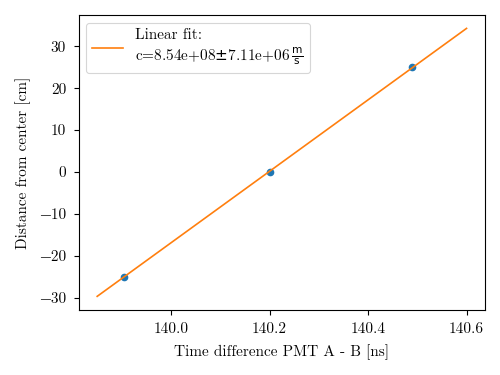

In [195]:
line = lambda x, a, b: a * x + b
cor_mean= [mean_b[0], mean_b[1], mean_b[2]+ 2*(mean_b[1]-mean_b[2])]
fig,ax = plt.subplots()
ax.plot(cor_mean,[-25,0,25], 'o')
popt, pcov = curve_fit(line, cor_mean, [-25,0,25])
x = np.linspace(139.85, 140.6, 1000)
ax.plot(x, line(x, *popt), label='Linear fit: \nc={:.2e}$\pm${:.2e}'.format(popt[0]*1e7, np.sqrt(pcov[0,0])*1e7)+'$\,\mathrm{\\frac{m}{s}}$')
ax.set(xlabel='Time difference PMT A - B [ns]', ylabel='Distance from center [cm]')
ax.legend()